In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as animation
import pandas as pd
import numpy as np
import helper
from scipy.signal import savgol_filter
import statsmodels.formula.api as smf

# Head-on scenario

## Preparing the data

In [111]:
# Calculate distance between the objects over time (fronting scenario)

def get_df_transformed(pp_ids, scenario): #scenario = 'crossing' or 'fronting'    
    df_plot= None
    appearances = ['sub', 'dom']
    columns_to_save = ["pp_id", "trial", "time", "x_human", "z_human", "x_spot", "z_spot", "distance", "Appearance"]
    
    for appearance in appearances:
        trials = helper.get_trial_list(scenario, appearance)

        for pp_id in pp_ids:
            path_Human = 'data/traj_data/id_' + pp_id + '/Human'
            path_Spot = 'data/traj_data/id_' + pp_id + '/Spot'

            for i in trials[int(pp_id)-1]:
                df_Human = pd.read_csv(path_Human + "/" + pp_id + "_"+ str(i) + ".csv", header = 0, names=["x_human", "z_human", "time"])
                df_Spot = pd.read_csv(path_Spot +  "/" + pp_id + "_"+ str(i) + ".csv", header = 0, names=["x_spot", "z_spot", "time"])
                
                # Check if the length of the dataframe matchs
                if not df_Human.size == df_Spot.size: 
                    print("Warning: Time stamp does not match!!!", pp_id, i)
                    break 

                # Concatenate to one dataframe
                df = pd.concat([df_Human.loc[:, :"z_human"], df_Spot], axis=1)
                # print("--- ", pp_id, i , " ---")
                
                # Calculate distance between two objects and append to list
                df['distance'] = np.sqrt((df['x_human']-df['x_spot'])**2 + (df['z_human']-df['z_spot'])**2)

                # Add some columns that can be useful later 
                df['trial'] = i
                df['pp_id'] = int(pp_id)
                if appearance =='sub':
                    df['Appearance'] = 'Submissive'
                if appearance == 'dom':
                    df['Appearance'] = 'Dominant'

                df_plot = pd.concat([df_plot, df.loc[:200, columns_to_save]], axis = 0)
    
    return df_plot

In [112]:
head_on_dynamics = get_df_transformed(pp_ids = ["%02d" % x for x in range(1, 22)], scenario='fronting')

Now let's smooth the data to get nicer trajectories

In [88]:
apply_filter = lambda traj: savgol_filter(traj, window_length=21, polyorder=2, axis=0)
groupby_cols = ["pp_id", "trial"]
cols_to_smooth = ["x_human", "z_human", "x_spot", "z_spot", "distance"]
head_on_dynamics.loc[:, cols_to_smooth] = (head_on_dynamics.loc[:, groupby_cols + cols_to_smooth].groupby(groupby_cols).transform(apply_filter))

participants = pd.read_csv("data/processed/participants.csv", index_col="Participant")
head_on_dynamics = head_on_dynamics.rename(columns={"pp_id": "Participant"})
head_on_dynamics = head_on_dynamics.join(participants["Experience"], on="Participant", how="left")

In [89]:
head_on_dynamics

,Participant,trial,time,x_human,z_human,x_spot,z_spot,distance,Appearance,Experience
0,1,2,0.0,6.729254,0.310807,0.381745,0.135653,6.349832,Submissive,In-person
1,1,2,0.1,6.744618,0.329546,0.420596,0.142910,6.326750,Submissive,In-person
2,1,2,0.2,6.754517,0.346026,0.460796,0.149623,6.296800,Submissive,In-person
3,1,2,0.3,6.758951,0.360246,0.502345,0.155792,6.259983,Submissive,In-person
4,1,2,0.4,6.757919,0.372206,0.545244,0.161417,6.216298,Submissive,In-person
...,...,...,...,...,...,...,...,...,...,...
160,21,15,16.0,-0.024746,-0.054019,6.265596,-0.108157,6.290577,Dominant,In-person
161,21,15,16.1,-0.025079,-0.054073,6.284160,-0.106545,6.309453,Dominant,In-person
162,21,15,16.2,-0.025500,-0.054145,6.300586,-0.105088,6.326280,Dominant,In-person
163,21,15,16.3,-0.026009,-0.054238,6.314872,-0.103785,6.341059,Dominant,In-person


In [90]:
head_on_dynamics.to_csv("data/processed/head_on_dynamics_processed.csv", index=False)

## Reading the processed data

In [91]:
participants = pd.read_csv("data/processed/participants.csv", index_col="Participant")
head_on_dynamics = pd.read_csv("data/processed/head_on_dynamics_processed.csv")

In [92]:
participants

,Rating,Sex,Age,Familiarity,Attitude,Experience,attitude_q
Participant,,,,,,,
1,3.40625,M,26,5,4,In-person,Positive
2,2.96875,M,27,3,4,Videos,Positive
3,3.03125,M,26,4,4,In-person,Positive
4,2.84375,M,26,4,1,In-person,Negative
5,3.46875,M,30,4,4,In-person,Positive
6,3.50000,M,23,3,5,Videos,Positive
7,4.09375,M,34,4,4,In-person,Positive
8,3.71875,M,27,5,5,In-person,Positive
9,3.15625,F,26,3,3,Videos,Negative


In [93]:
head_on_dynamics

,Participant,trial,time,x_human,z_human,x_spot,z_spot,distance,Appearance,Experience
0,1,2,0.0,6.729254,0.310807,0.381745,0.135653,6.349832,Submissive,In-person
1,1,2,0.1,6.744618,0.329546,0.420596,0.142910,6.326750,Submissive,In-person
2,1,2,0.2,6.754517,0.346026,0.460796,0.149623,6.296800,Submissive,In-person
3,1,2,0.3,6.758951,0.360246,0.502345,0.155792,6.259983,Submissive,In-person
4,1,2,0.4,6.757919,0.372206,0.545244,0.161417,6.216298,Submissive,In-person
...,...,...,...,...,...,...,...,...,...,...
57539,21,15,16.0,-0.024746,-0.054019,6.265596,-0.108157,6.290577,Dominant,In-person
57540,21,15,16.1,-0.025079,-0.054073,6.284160,-0.106545,6.309453,Dominant,In-person
57541,21,15,16.2,-0.025500,-0.054145,6.300586,-0.105088,6.326280,Dominant,In-person
57542,21,15,16.3,-0.026009,-0.054238,6.314872,-0.103785,6.341059,Dominant,In-person


## Walking trajectories

One trajectory

In [94]:
traj = head_on_dynamics[(head_on_dynamics.Participant==1) & (head_on_dynamics.trial==2)]

In [95]:
traj

,Participant,trial,time,x_human,z_human,x_spot,z_spot,distance,Appearance,Experience
0,1,2,0.0,6.729254,0.310807,0.381745,0.135653,6.349832,Submissive,In-person
1,1,2,0.1,6.744618,0.329546,0.420596,0.142910,6.326750,Submissive,In-person
2,1,2,0.2,6.754517,0.346026,0.460796,0.149623,6.296800,Submissive,In-person
3,1,2,0.3,6.758951,0.360246,0.502345,0.155792,6.259983,Submissive,In-person
4,1,2,0.4,6.757919,0.372206,0.545244,0.161417,6.216298,Submissive,In-person
...,...,...,...,...,...,...,...,...,...,...
123,1,2,12.3,-0.030066,-0.043841,6.144606,0.262446,6.182309,Submissive,In-person
124,1,2,12.4,-0.030325,-0.045163,6.174791,0.253932,6.212362,Submissive,In-person
125,1,2,12.5,-0.030682,-0.046834,6.202728,0.244561,6.240249,Submissive,In-person
126,1,2,12.6,-0.031136,-0.048855,6.228419,0.234335,6.265970,Submissive,In-person


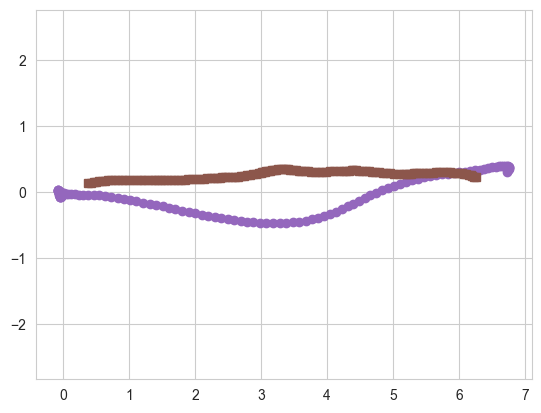

In [98]:
fig, ax = plt.subplots()
ax.axis("equal")
ax.plot(traj.x_human, traj.z_human, color="C4", marker="o", label="Human")
ax.plot(traj.x_spot, traj.z_spot, color="C5", marker="s", label="Robot")

All trajectories of one participant

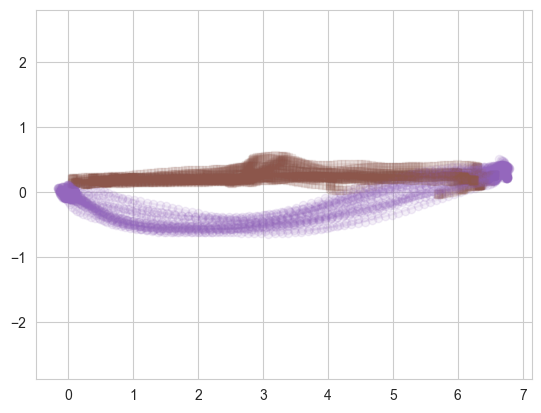

In [99]:
fig, ax = plt.subplots()
ax.axis("equal")
head_on_dynamics_p_1 = head_on_dynamics[head_on_dynamics.Participant==1] 
for trial, traj in head_on_dynamics_p_1.groupby("trial"):
    ax.plot(traj.x_human, traj.z_human, color="C4", marker="o", label="Human", alpha=0.1)
    ax.plot(traj.x_spot, traj.z_spot, color="C5", marker="s", label="Robot", alpha=0.1)

All trajectories of all participants

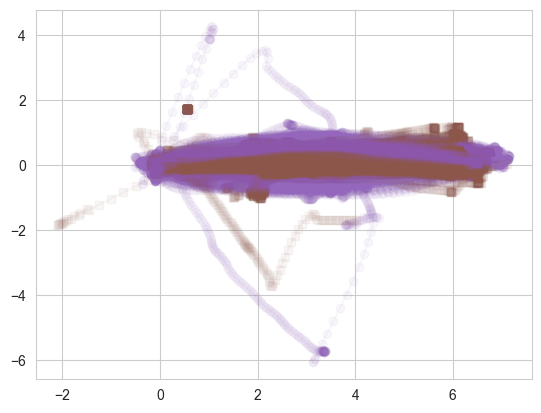

In [101]:
fig, ax = plt.subplots() 
for traj_name, traj in head_on_dynamics.groupby(["Participant", "trial"]):
    ax.plot(traj.x_human, traj.z_human, color="C4", marker="o", label="Human", alpha=0.05)
    ax.plot(traj.x_spot, traj.z_spot, color="C5", marker="s", label="Robot", alpha=0.05)

(-1.5, 1.5)

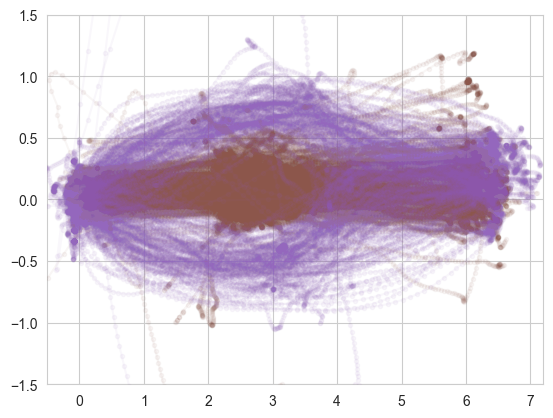

In [110]:
fig, ax = plt.subplots() 
for traj_name, traj in head_on_dynamics.groupby(["Participant", "trial"]):
    ax.plot(traj.x_human, traj.z_human, color="C4", marker=".", label="Human", alpha=0.05, zorder=200)
    ax.plot(traj.x_spot, traj.z_spot, color="C5", marker=".", label="Robot", alpha=0.05, zorder=100)
ax.set_xlim([-0.5, 7.2])
ax.set_ylim([-1.5, 1.5])   

## Distance: Dominant vs submissive

D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

<Axes: xlabel='time', ylabel='distance'>

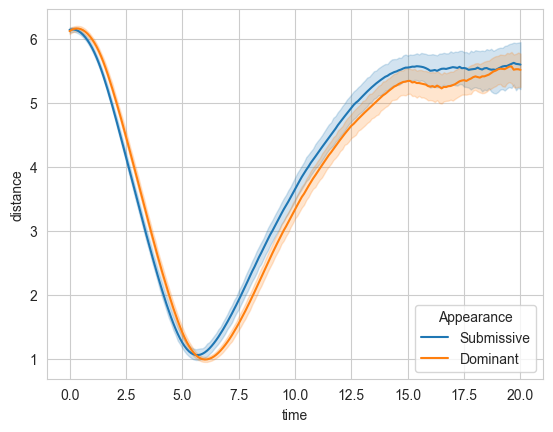

In [32]:
sns.lineplot(data=head_on_dynamics, x='time', y='distance', hue="Appearance")

D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

<Axes: xlabel='time', ylabel='distance_s'>

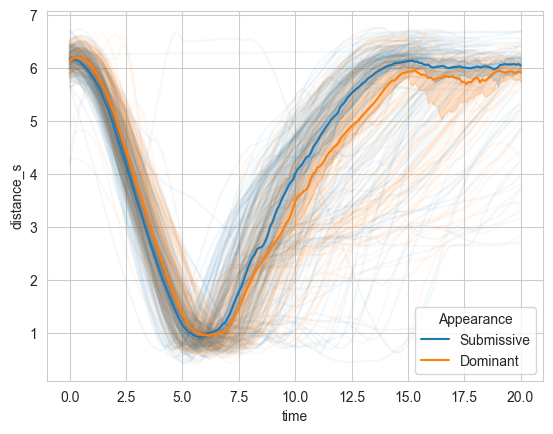

In [14]:
fig, ax = plt.subplots()
for name, traj in head_on_dynamics.groupby(["Participant", "trial"]):
    appearance = traj.Appearance.iloc[0]
    ax.plot(traj.time, traj.distance_s, color="C0" if appearance=="Submissive" else "C1", alpha=0.05)
sns.lineplot(data=head_on_dynamics, x='time', y='distance_s', hue="Appearance", estimator=np.median, ax=ax)

## Distance: With and without in-person experience

D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

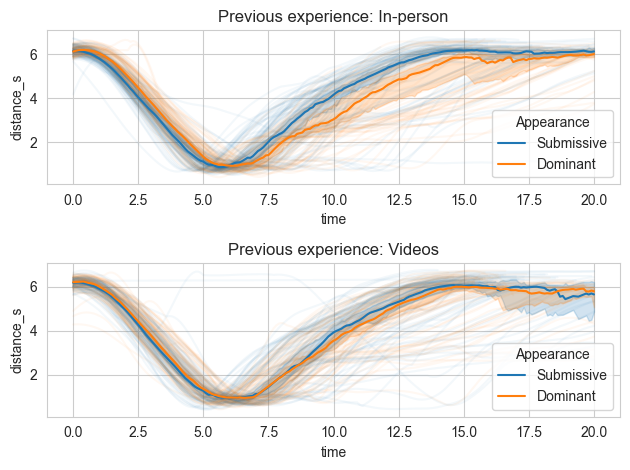

In [30]:
fig, axes = plt.subplots(2, 1)
for ax, experience in zip(axes, ["In-person", "Videos"]):
    for name, traj in head_on_dynamics[head_on_dynamics.Experience==experience].groupby(["Participant", "trial"]):
        appearance = traj.Appearance.iloc[0]
        ax.plot(traj.time, traj.distance_s, color="C0" if appearance=="Submissive" else "C1", alpha=0.05)
    sns.lineplot(data=head_on_dynamics[head_on_dynamics.Experience==experience], 
                 x="time", y="distance_s", hue="Appearance", estimator=np.median, 
                 palette=["C0", "C1"], ax=ax)
    ax.set_title("Previous experience: %s" % (experience))
    
plt.tight_layout()
plt.savefig("head_on_distance_over_time_by_experience.png", dpi=300, bbox_inches="tight")

D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

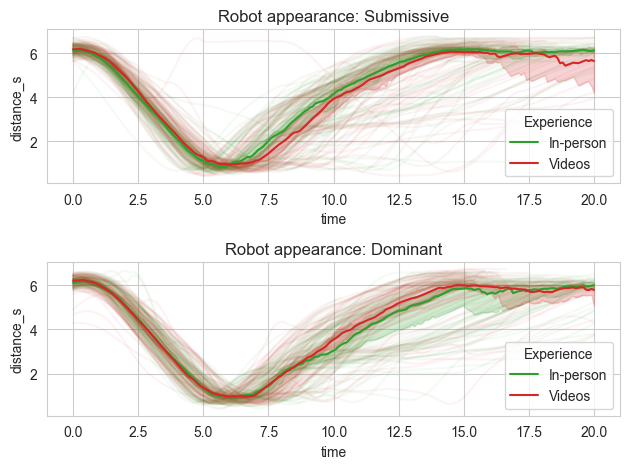

In [28]:
fig, axes = plt.subplots(2, 1)
for ax, appearance in zip(axes, ["Submissive", "Dominant"]):
    for name, traj in head_on_dynamics[head_on_dynamics.Appearance==appearance].groupby(["Participant", "trial"]):
        # appearance = traj.Appearance.iloc[0]
        experience = traj.Experience.iloc[0]
        ax.plot(traj.time, traj.distance_s, color="C2" if experience=="In-person" else "C3", alpha=0.05)
    sns.lineplot(data=head_on_dynamics[head_on_dynamics.Appearance==appearance], 
                 x="time", y="distance_s", hue="Experience", estimator=np.median, 
                 palette=["C2", "C3"], ax=ax)
    ax.set_title("Robot appearance: %s" % (appearance))
    
plt.tight_layout()
plt.savefig("head_on_distance_over_time_by_appearance.png", dpi=300, bbox_inches="tight")

## Distance: Differences in trials over time

### For both appearances

D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN befo

<Axes: xlabel='time', ylabel='distance'>

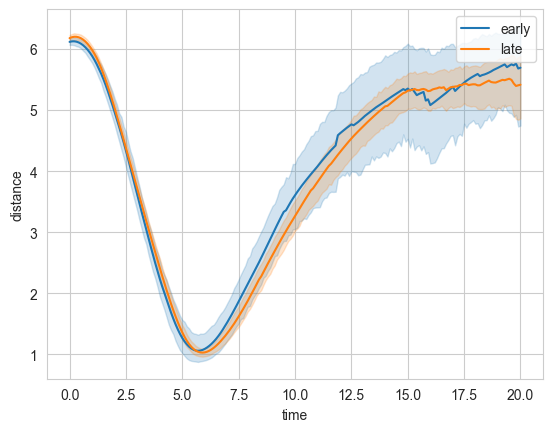

In [37]:
sns.lineplot(data=head_on_dynamics[(head_on_dynamics.trial.isin([1, 17]))], 
             x="time", y="distance", label="early")
sns.lineplot(data=head_on_dynamics[(head_on_dynamics.trial.isin([13, 14, 15, 16, 29, 30, 31, 32]))], 
             x="time", y="distance", label="late")

### For submissive

<Axes: xlabel='time', ylabel='distance_s'>

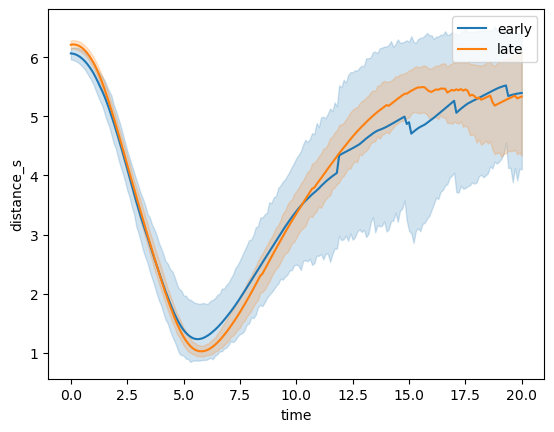

In [15]:
sns.lineplot(data=head_on_dynamics[(head_on_dynamics.trial.isin([1, 17])) & (head_on_dynamics["Appearance"]=="Submissive")], 
             x="time", y="distance_s", label="early")
sns.lineplot(data=head_on_dynamics[(head_on_dynamics.trial.isin([13, 14, 15, 16, 29, 30, 31, 32]))& (head_on_dynamics["Appearance"]=="Submissive")], 
             x="time", y="distance_s", label="late")

### For dominant

<Axes: xlabel='time', ylabel='distance_s'>

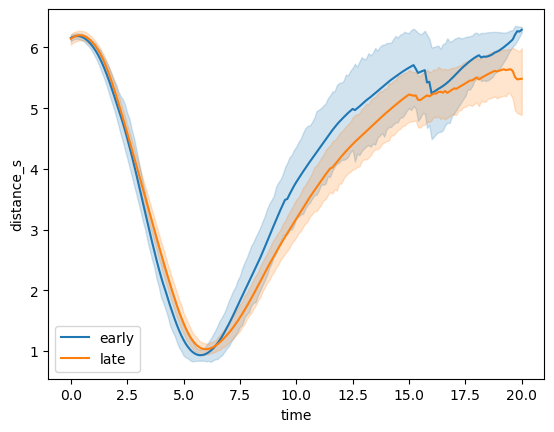

In [16]:
sns.lineplot(data=head_on_dynamics[(head_on_dynamics.trial.isin([1, 17])) & (head_on_dynamics["Appearance"]=="Dominant")], 
             x="time", y="distance_s", label="early")
sns.lineplot(data=head_on_dynamics[(head_on_dynamics.trial.isin([13, 14, 15, 16, 29, 30, 31, 32]))& (head_on_dynamics["Appearance"]=="Dominant")], 
             x="time", y="distance_s", label="late")

## Metrics: Getting metrics for each trajectory

In [9]:
def get_min_distance(traj):
    idx_min = traj.distance_s.idxmin()
    return pd.Series({"idx_min": idx_min,
                      "t_min": traj.iloc[idx_min].time, 
                      "d_min": traj.iloc[idx_min].distance_s}) 

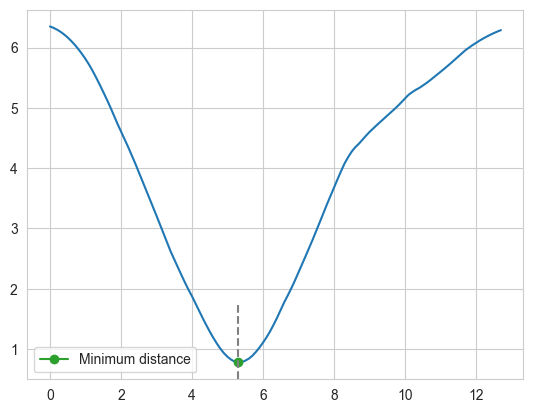

In [10]:
traj = head_on_dynamics[(head_on_dynamics.Participant==1) & (head_on_dynamics.trial==2)]
fig, ax = plt.subplots(1)
ax.plot(traj.time, traj.distance_s)
traj_measures = get_min_distance(traj)
ax.plot(traj_measures.t_min, traj_measures.d_min, label="Minimum distance", color="C2", marker="o")
ax.axvline(traj_measures.t_min, ymin=0, ymax=0.2, color="grey", ls="--")
plt.legend()

In [40]:
distance_metrics = (head_on_dynamics.groupby(["Participant", "trial"])
                    .apply(get_min_distance)
                    .join(head_on_dynamics.groupby(["Participant", "trial"]).first()[["Appearance", "Experience"]])
                    .reset_index())

In [41]:
distance_metrics

,Participant,trial,idx_min,t_min,d_min,Appearance,Experience
0,1,1,51.0,5.1,0.608186,Dominant,In-person
1,1,2,53.0,5.3,0.778055,Submissive,In-person
2,1,3,53.0,5.3,0.704137,Submissive,In-person
3,1,4,61.0,6.1,0.930015,Dominant,In-person
4,1,5,57.0,5.7,0.745893,Submissive,In-person
...,...,...,...,...,...,...,...
322,21,12,60.0,6.0,0.631903,Dominant,In-person
323,21,13,56.0,5.6,0.769273,Submissive,In-person
324,21,14,62.0,6.2,0.710637,Dominant,In-person
325,21,15,59.0,5.9,0.699368,Dominant,In-person


## Metrics: Analyses

### Time of resolving the conflict

Let's look at the average time of resolving the conflict (e.g. time at which distance between the human and the spot was minimal)

In [31]:
distance_metrics[distance_metrics.Appearance=="Dominant"].t_min.mean(), distance_metrics[distance_metrics.Appearance=="Submissive"].t_min.mean()

(6.490566037735849, 6.255952380952381)

It seems that in interactions with the submissive robot, participants were slightly faster reaching it (difference of 230ms)

D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

<Axes: xlabel='Appearance', ylabel='t_min'>

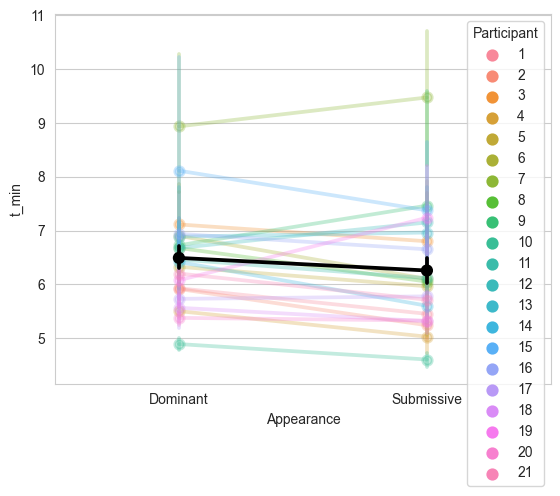

In [42]:
ax = sns.pointplot(data=distance_metrics, x="Appearance", y="t_min", hue="Participant")
plt.setp(ax.collections, alpha=.3, zorder=1) #for the markers
plt.setp(ax.lines, alpha=.3, zorder=1)
sns.pointplot(data=distance_metrics, x="Appearance", y="t_min", color="black", ax=ax)

D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Time when human and robot pass each other')

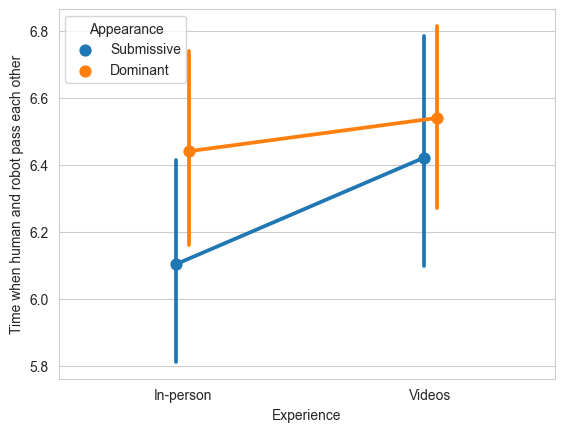

In [49]:
ax = sns.pointplot(data=distance_metrics, x="Experience", y="t_min", hue="Appearance", hue_order=["Submissive", "Dominant"], dodge=True)
ax.set_ylabel("Time when human and robot pass each other")

But what if we take into account the individual differences in baseline t_min/speed?
 - Mixed-effects model estimates the difference to be smaller (184ms difference between dominant and submissive)
  - It is not statistically significant (p=0.14)

In [48]:
mdf_t = smf.mixedlm("t_min ~ Appearance*Experience", distance_metrics.reset_index(), groups=distance_metrics.reset_index()["Participant"]).fit()
print(mdf_t.summary())

                         Mixed Linear Model Regression Results
Model:                       MixedLM            Dependent Variable:            t_min    
No. Observations:            327                Method:                        REML     
No. Groups:                  21                 Scale:                         1.2589   
Min. group size:             9                  Log-Likelihood:                -528.2024
Max. group size:             16                 Converged:                     Yes      
Mean group size:             15.6                                                       
----------------------------------------------------------------------------------------
                                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------
Intercept                                      6.358    0.318 20.025 0.000  5.736  6.981
Appearance[T.Submissive]                      -

### Safety margin

The safety margins adopted by participants appear very similar (73-74cm)

In [115]:
distance_metrics[distance_metrics.Appearance=="Dominant"].d_min.mean(), distance_metrics[distance_metrics.Appearance=="Submissive"].d_min.mean()

(0.7406215327107739, 0.7346270749264817)

<Axes: >

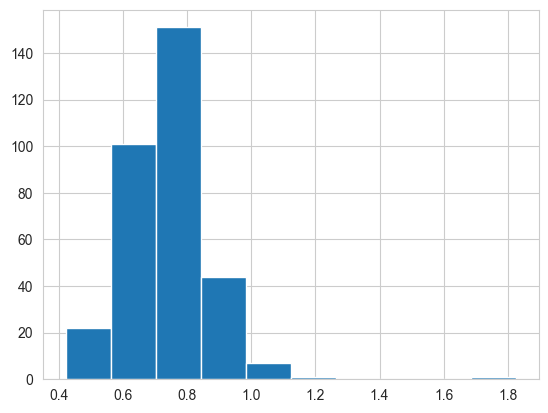

In [116]:
distance_metrics.d_min.hist()

<Axes: xlabel='Appearance', ylabel='d_min'>

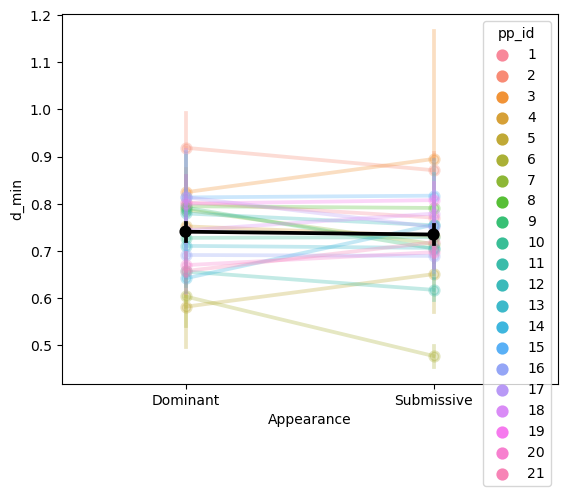

In [25]:
ax = sns.pointplot(data=distance_metrics, x="Appearance", y="d_min", hue="Participant")
plt.setp(ax.collections, alpha=.3, zorder=1) #for the markers
plt.setp(ax.lines, alpha=.3, zorder=1)
sns.pointplot(data=distance_metrics, x="Appearance", y="d_min", color="black", ax=ax)

Here too, there is no evidence for a significant difference between dominant and submissive Spot

D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


(0.5, 1.0)

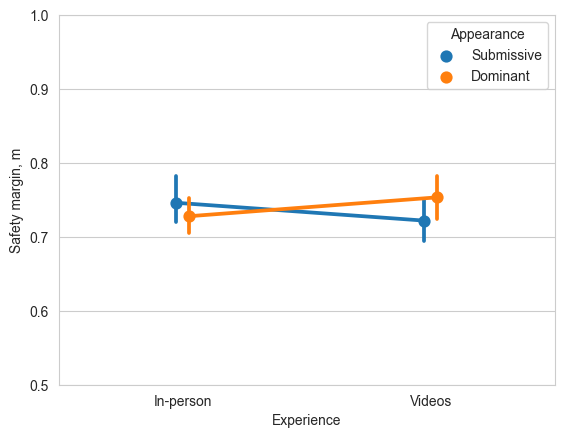

In [52]:
ax = sns.pointplot(data=distance_metrics, x="Experience", y="d_min", hue="Appearance", hue_order=["Submissive", "Dominant"], dodge=True)
ax.set_ylabel("Safety margin, m")
ax.set_ylim((0.5, 1.0))

In [50]:
mdf_d = smf.mixedlm("d_min ~ Appearance*Experience", distance_metrics.reset_index(), groups=distance_metrics.reset_index()["Participant"]).fit()
print(mdf_d.summary())

                         Mixed Linear Model Regression Results
Model:                        MixedLM            Dependent Variable:            d_min   
No. Observations:             327                Method:                        REML    
No. Groups:                   21                 Scale:                         0.0113  
Min. group size:              9                  Log-Likelihood:                235.5263
Max. group size:              16                 Converged:                     Yes     
Mean group size:              15.6                                                      
----------------------------------------------------------------------------------------
                                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------
Intercept                                      0.727    0.027 27.023 0.000  0.674  0.780
Appearance[T.Submissive]                       

D:\source\Spot-DataAnalysis\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [55]:
mdf_d = smf.mixedlm("d_min ~ Appearance", distance_metrics[distance_metrics.Experience=="Videos"].reset_index(), groups=distance_metrics[distance_metrics.Experience=="Videos"].reset_index()["Participant"]).fit()
print(mdf_d.summary())

               Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     d_min   
No. Observations:      159         Method:                 REML    
No. Groups:            10          Scale:                  0.0090  
Min. group size:       15          Log-Likelihood:         129.4299
Max. group size:       16          Converged:              Yes     
Mean group size:       15.9                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.754    0.033 23.176 0.000  0.690  0.818
Appearance[T.Submissive] -0.032    0.015 -2.122 0.034 -0.062 -0.002
Group Var                 0.009    0.051                           


D:\source\Spot-DataAnalysis\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


### Safety margin by trial number

In [141]:
distance_metrics["Early/Late"] = None
distance_metrics.loc[(distance_metrics.trial==1) | (distance_metrics.trial==17), ["Early/Late"]] = "Early"
distance_metrics.loc[(distance_metrics.trial==16) | (distance_metrics.trial==32), ["Early/Late"]] = "Late"

D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

<Axes: xlabel='Appearance', ylabel='d_min'>

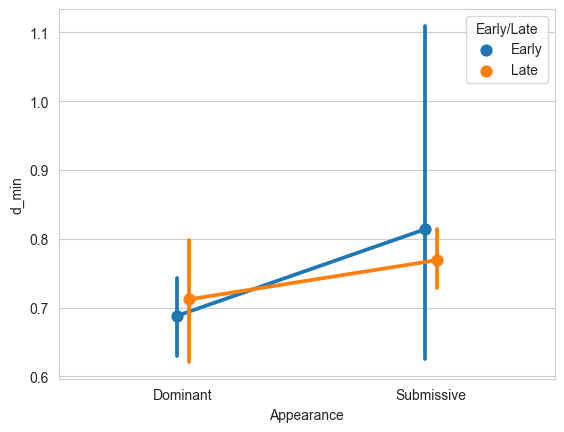

In [142]:
sns.pointplot(data=distance_metrics, x="Appearance", y="d_min", hue="Early/Late", dodge=True)

# Crossing scenario

In [2]:
def get_crossing_df(pp_ids):
    
    df_plot= None
    appearances = ['sub', 'dom']
    
    for appearance in appearances:
        trials = helper.get_trial_list('crossing', appearance)

        for pp_id in pp_ids:
            path_Human = './traj_data/id_' + pp_id + '/Human'
            path_Spot = './traj_data/id_' + pp_id + '/Spot'

            for i in trials[int(pp_id)-1]:
                df_Human = pd.read_csv(path_Human + "/" + pp_id + "_"+ str(i) + ".csv", header = 0, names=["x_human", "z_human", "time"])
                df_Spot = pd.read_csv(path_Spot +  "/" + pp_id + "_"+ str(i) + ".csv", header = 0, names=["x_spot", "z_spot", "time"])
                
                # Check if the length of the dataframe matchs
                if not df_Human.size == df_Spot.size: 
                    print("Warning: Time stamp does not match!!!")
                    break 

                # Concatenate to one dataframe
                df = pd.concat([df_Human.loc[:, :"z_human"], df_Spot], axis=1)
                # print("--- ", pp_id, i , " ---")
                
                # print(df)
                
                # Calculate distance between two objects and append to list
                #df['distance'] = np.sqrt((df['x_human']-df['x_spot'])**2 + (df['z_human']-df['z_spot'])**2)

                # Add some columns that can be useful later 
                df['trial'] = i
                df['pp_id'] = int(pp_id)
                df['appearance'] = appearance

                df_plot = pd.concat([df_plot, df], axis = 0)
    
    return df_plot

In [75]:
df_crossing = get_crossing_df(pp_ids= ["%02d" % x for x in range(1, 22)])

In [4]:
df_crossing

,x_human,z_human,x_spot,z_spot,time,trial,pp_id,appearance
0,3.076976,2.942762,0.565110,0.251261,0.0,17,1,sub
1,3.082519,2.939923,0.565004,0.251831,0.1,17,1,sub
2,3.087497,2.937073,0.565523,0.251313,0.2,17,1,sub
3,3.092433,2.933979,0.577094,0.255493,0.3,17,1,sub
4,3.095552,2.931347,0.599582,0.261267,0.4,17,1,sub
...,...,...,...,...,...,...,...,...
167,3.345903,-2.695228,5.572216,-0.289826,16.7,32,21,dom
168,3.346524,-2.695680,5.572162,-0.289879,16.8,32,21,dom
169,3.344801,-2.695878,5.572354,-0.290144,16.9,32,21,dom
170,3.344738,-2.695881,5.571944,-0.289819,17.0,32,21,dom


### Preprocess the data

In [76]:
apply_filter = lambda traj: savgol_filter(traj, window_length=21, polyorder=2, axis=0)
groupby_cols = ["pp_id", "trial"]
cols_to_smooth = ["x_human", "z_human", "x_spot", "z_spot"]
df_crossing.loc[:, ["x_human", "z_human", "x_spot", "z_spot"]] = (df_crossing.loc[:, groupby_cols + cols_to_smooth].groupby(groupby_cols).transform(apply_filter))

mean_positions = df_crossing.loc[df_crossing["time"] == 0.0, ["x_human", "z_human", "x_spot", "z_spot"]].mean()
df_crossing.loc[:, "distance_to_crossing_human"] = np.sqrt((df_crossing.x_human - mean_positions.x_human)**2 + (df_crossing.z_human - mean_positions.z_spot)**2)
df_crossing.loc[:, "distance_to_crossing_robot"] = np.sqrt((df_crossing.x_spot - mean_positions.x_human)**2 + (df_crossing.z_spot - mean_positions.z_spot)**2)

## Starting and final positions

In [60]:
starting_positions = df_crossing.groupby(["pp_id", "trial"]).first()
final_positions = df_crossing.groupby(["pp_id", "trial"]).last()

In [61]:
mean_positions

x_human    3.287721
z_human    0.156674
x_spot     0.045819
z_spot     0.046766
dtype: float64

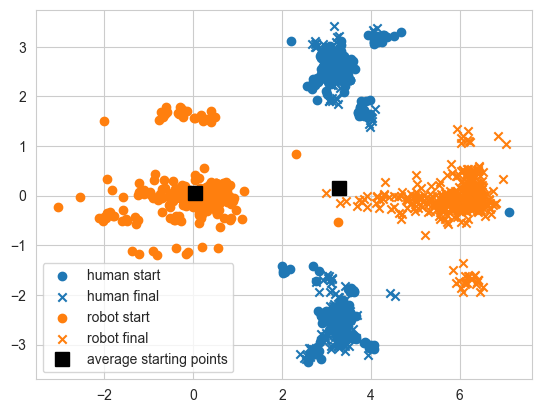

In [62]:
fig, ax = plt.subplots()
ax.scatter(starting_positions.x_human, starting_positions.z_human, color="C0", marker="o", label="human start")
ax.scatter(final_positions.x_human, final_positions.z_human, color="C0", marker="x", label="human final")
ax.scatter(starting_positions.x_spot, starting_positions.z_spot, color="C1", marker="o", label="robot start")
ax.scatter(final_positions.x_spot, final_positions.z_spot, color="C1", marker="x", label="robot final")
ax.plot(mean_positions.x_human, mean_positions.z_human, color="k", ls="", marker="s", ms=10, label="average starting points")
ax.plot(mean_positions.x_spot, mean_positions.z_spot, color="k", marker="s", ms=10)
ax.legend()

Let's assume HCP(Hypothetical crossing point): (x, z) = (3.28, 0). In this transformed coordinate, Spot always start from 
approximately (0, 0).

## Illustrating one crossing trial

In [144]:
trial = df_crossing[(df_crossing.pp_id==1) & (df_crossing.trial==17)]

In [145]:
trial

,x_human,z_human,x_spot,z_spot,time,trial,pp_id,appearance,distance_to_crossing_human,distance_to_crossing_robot
0,3.083396,2.919734,0.527394,0.254232,0.0,17,1,sub,2.880224,2.768112
1,3.087707,2.927833,0.547486,0.255470,0.1,17,1,sub,2.888001,2.748171
2,3.091143,2.934354,0.570356,0.256753,0.2,17,1,sub,2.894272,2.725466
3,3.093706,2.939298,0.596003,0.258081,0.3,17,1,sub,2.899032,2.700000
4,3.095395,2.942664,0.624428,0.259453,0.4,17,1,sub,2.902277,2.671772
...,...,...,...,...,...,...,...,...,...,...
212,3.491367,-2.386353,6.507973,0.233698,21.2,17,1,sub,2.441627,3.225673
213,3.489074,-2.386094,6.506428,0.231998,21.3,17,1,sub,2.441178,3.224032
214,3.486266,-2.385737,6.505023,0.229736,21.4,17,1,sub,2.440592,3.222501
215,3.482943,-2.385282,6.503760,0.226911,21.5,17,1,sub,2.439870,3.221080


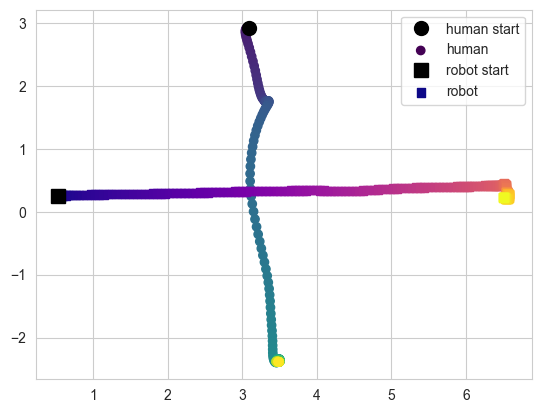

In [65]:
fig, ax = plt.subplots()
ax.plot(trial.x_human[0], trial.z_human[0], color="k", ls="", marker="o", ms=10, label="human start")
ax.scatter(trial.x_human, trial.z_human, c=cm.viridis(trial.time/trial.time.max()), marker="o", label="human")
ax.plot(trial.x_spot[0], trial.z_spot[0], color="k", ls="", marker="s", ms=10, label="robot start")
ax.scatter(trial.x_spot, trial.z_spot, c=cm.plasma(trial.time/trial.time.max()), marker="s", label="robot")
ax.legend()

## Animation

# Trajectories
### Note: Coordinate of participants 11~13 is not aligned to the axis :( I am still figuring out why. 

Animations are better saved in a gif file, it's tricky to render them reliably in a Jupyter notebook. Saving does take some time though

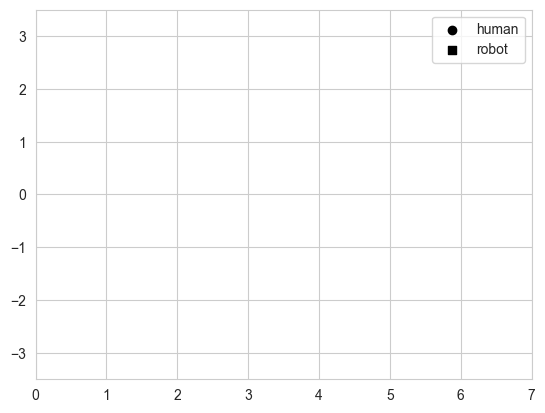

In [51]:
# set dt to 50ms to get 2x speed-up in the animation
# to keep the original speed, set dt to 100 ms
dt = 50 #ms
fig, ax = plt.subplots()

traj_human = ax.scatter(trial.x_human[0], trial.z_human[0], c="k", marker="o", label="human")
traj_robot = ax.scatter(trial.x_spot[0], trial.z_spot[0], c="k", marker="s", label="robot")

ax.set(xlim=[0, 7], ylim=[-3.5, 3.5])
ax.legend()

def update(frame):
    data_human = np.stack([trial.x_human[:frame], trial.z_human[:frame]]).T
    data_robot = np.stack([trial.x_spot[:frame], trial.z_spot[:frame]]).T
    traj_human.set_offsets(data_human)
    traj_robot.set_offsets(data_robot)
    return (traj_human, traj_robot)

ani = animation.FuncAnimation(fig=fig, func=update, frames=len(trial), interval=dt)
ani.save("crossing_trial.gif", writer="pillow", fps=1000/dt)

## Getting the metrics

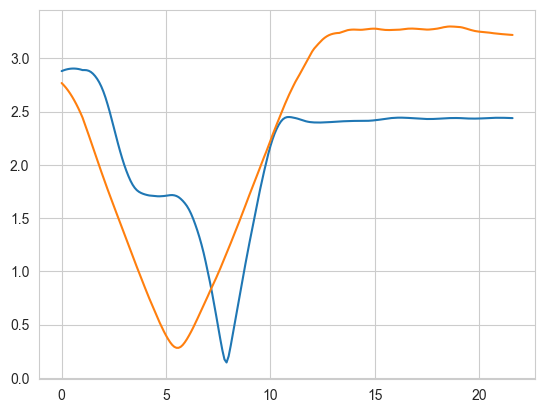

In [146]:
plt.plot(trial.time, trial.distance_to_crossing_human, label="human")
plt.plot(trial.time, trial.distance_to_crossing_robot, label="robot")

In [77]:
def get_t_crossing(traj):
    idx_min_human = traj.distance_to_crossing_human.idxmin()
    idx_min_robot = traj.distance_to_crossing_robot.idxmin()
    return pd.Series({"idx_min_human": idx_min_human,
                      "idx_min_robot": idx_min_robot,
                      "t_crossing_human": traj.iloc[idx_min_human].time, 
                      "t_crossing_robot": traj.iloc[idx_min_robot].time})

crossing_metrics = (df_crossing.groupby(["pp_id", "trial"])
                    .apply(get_t_crossing)
                    .join(df_crossing.groupby(["pp_id", "trial"]).first()["appearance"])
                    .reset_index())

In [79]:
crossing_metrics["is_human_first"] = crossing_metrics["t_crossing_human"] < crossing_metrics["t_crossing_robot"]
crossing_metrics["crossed_first"] = "robot"
crossing_metrics.loc[crossing_metrics.is_human_first, ["crossed_first"]] = "human"

In [80]:
crossing_metrics

,pp_id,trial,idx_min_human,idx_min_robot,t_crossing_human,t_crossing_robot,appearance,is_human_first,crossed_first
0,1,17,79.0,56.0,7.9,5.6,sub,False,robot
1,1,18,37.0,86.0,3.7,8.6,dom,True,human
2,1,19,39.0,66.0,3.9,6.6,dom,True,human
3,1,20,34.0,58.0,3.4,5.8,sub,True,human
4,1,21,75.0,54.0,7.5,5.4,sub,False,robot
...,...,...,...,...,...,...,...,...,...
330,21,28,41.0,75.0,4.1,7.5,sub,True,human
331,21,29,43.0,76.0,4.3,7.6,dom,True,human
332,21,30,40.0,80.0,4.0,8.0,sub,True,human
333,21,31,41.0,73.0,4.1,7.3,sub,True,human


## Who crossed first?

D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

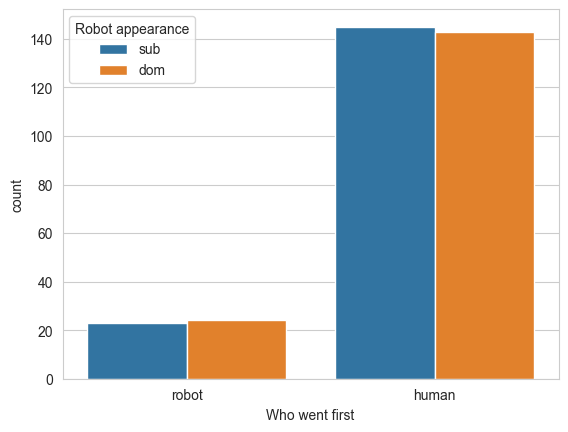

In [97]:
fig, ax = plt.subplots()
g = sns.countplot(data=crossing_metrics, x="crossed_first", hue="appearance", ax=ax)
ax.set_xlabel("Who went first")
g.legend().set_title("Robot appearance")
# g.legend.set_title("TTA")

D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

Text(0, 0.5, '% human went first')

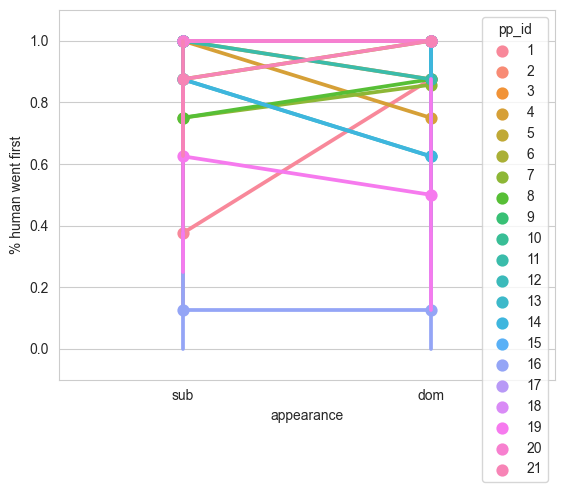

In [119]:
fig, ax = plt.subplots()
sns.pointplot(data=crossing_metrics, y="is_human_first", x="appearance", hue="pp_id", ax=ax)
ax.set_ylim((-0.1,1.1))
ax.set_ylabel("% human went first")

## Crossing trajectories

D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN befo

<Axes: xlabel='time', ylabel='distance_to_crossing_human'>

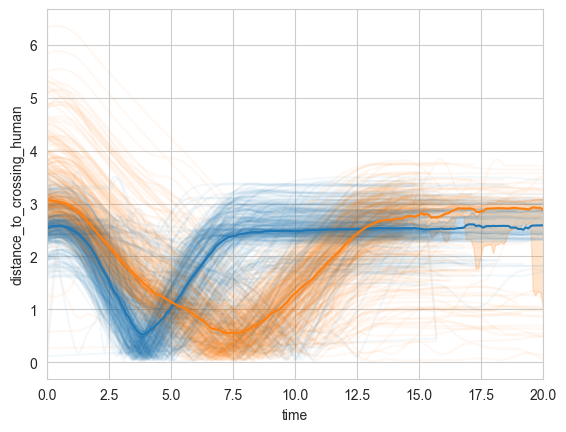

In [154]:
fig, ax = plt.subplots()
for name, traj in df_crossing.groupby(["pp_id", "trial"]):
    # appearance = traj.Appearance.iloc[0]
    ax.plot(traj.time, traj.distance_to_crossing_human, color="C0", alpha=0.05)
    ax.plot(traj.time, traj.distance_to_crossing_robot, color="C1", alpha=0.05)
ax.set_xlim((0, 20))
sns.lineplot(data=df_crossing, x='time', y='distance_to_crossing_human', color="C0", estimator=np.median, ax=ax)
sns.lineplot(data=df_crossing, x='time', y='distance_to_crossing_robot', color="C1", estimator=np.median, ax=ax)

In [31]:
def get_trajectory_df(pp_ids, apparance, position_of, scenario):
    
    df_plot= None
    
    #Iterate over participants
    for pp_id in pp_ids:
        path = './traj_data/id_' + pp_id + '/' + position_of
       # path_Spot = './traj_data/id_' + pp_id + '/Spot'

        trials = helper.get_trial_list(scenario, apparance)
        
        # Add each trial to one dataframe
        for i in trials[int(pp_id)-1]:
            df = pd.read_csv(path + "/" + pp_id + "_"+ str(i) + ".csv")
            
            # Add some columns that can be useful later 
            df['trial'] = str(i)
            df['pp_id'] = pp_id
            # print(df['z'])
            df['z'] = df['z'] - df.loc[0]['z'] # To adjust noise in the start 
            
            df_plot = pd.concat([df_plot, df.loc[:200]], axis = 0)
            
    return df_plot

<Axes: xlabel='x', ylabel='z'>

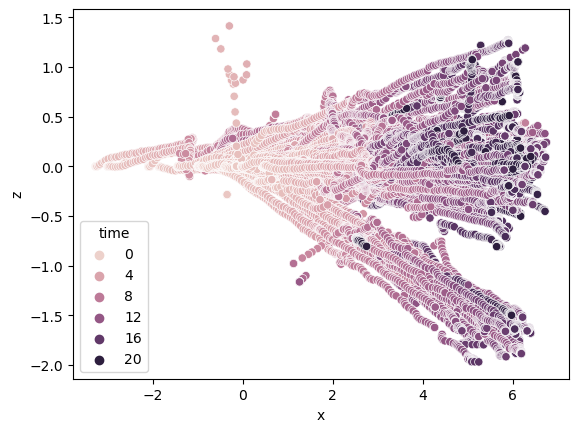

In [32]:
## First, plot all the trajectory points for Spot (dominant)

df_traj_Spot = get_trajectory_df(pp_ids = ["%02d" % x for x in range(1, 22)], apparance = 'dom', position_of = 'Spot', scenario = 'fronting');
sns.scatterplot(data = df_traj_Spot.loc[: , ['x', 'z', 'time']], x = 'x', y = 'z', hue = 'time')

<Axes: xlabel='x', ylabel='z'>

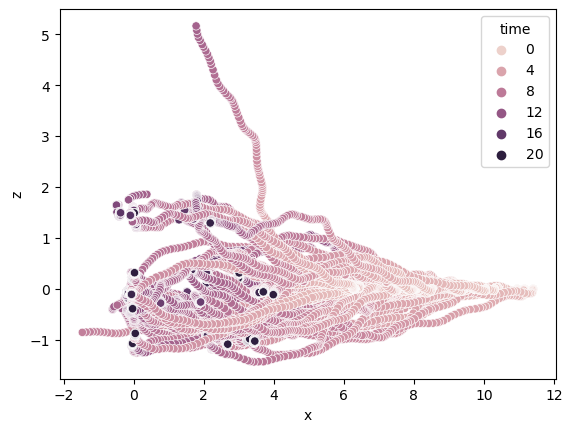

In [33]:
# Human, dominant
df_traj_Human = get_trajectory_df(pp_ids =  ["%02d" % x for x in range(1, 12)], apparance = 'dom', position_of = 'Human', scenario = 'fronting');
sns.scatterplot(data = df_traj_Human.loc[: , ['x', 'z', 'time']], x = 'x', y = 'z', hue = 'time' )

In [34]:
#sns.lineplot(data = df_traj_Human.loc[:, ['x', 'z','time']], x = 'x', y = 'z')
# Line plot is ugly here

C:\Users\nanap\AppData\Local\Temp\ipykernel_1840\2388284595.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_traj_Spot_pp = df_traj_Spot.groupby(['pp_id']).mean()


<Axes: xlabel='x', ylabel='z'>

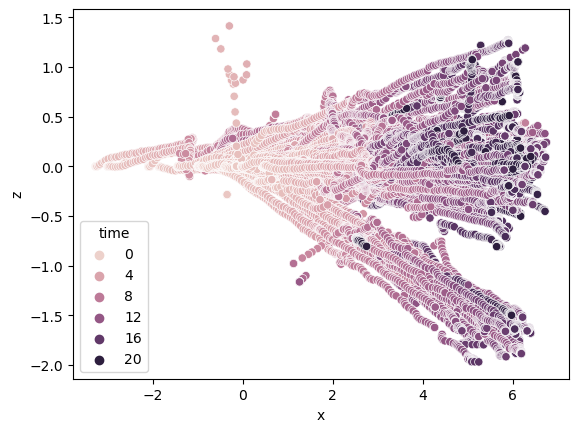

In [35]:
# Next idea
# Groupby participants -> draw 21 trajectories??
# (This part is not done.)

df_traj_Spot_pp = df_traj_Spot.groupby(['pp_id']).mean()
sns.scatterplot(data = df_traj_Spot.loc[: , ['x', 'z', 'time']], x = 'x', y = 'z', hue = 'time')